In [1]:

# %%
# Import principali (no seaborn, solo matplotlib per i grafici)
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# %%
# --- Input percorso dataset ---
# Inserisci il percorso del file; se lasci vuoto usa quello di default
default_path = "profumi_dataset.csv"
print("Inserisci il percorso del dataset (lascia vuoto per usare il default):")
try:
    user_path = input().strip()
except Exception:
    user_path = ""
path = user_path if user_path else default_path
print("Userà:", path)


Inserisci il percorso del dataset (lascia vuoto per usare il default):


Userà: profumi_dataset.csv


In [3]:

# %%
# Funzione di lettura "difensiva": prova Excel con più engine e poi CSV/TSV
def robust_read_defensive(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in [".xls", ".xlsx"]:
        for engine in ["xlrd", "openpyxl", None]:
            try:
                return pd.read_excel(path, engine=engine)
            except Exception:
                pass
        # Fallback CSV/TSV
        for sep in [",", ";", "\t", "|"]:
            try:
                return pd.read_csv(path, sep=sep)
            except Exception:
                continue
        raise ValueError("Impossibile leggere il file come Excel né come CSV/TSV.")
    # Non-Excel: prova CSV/TSV vari
    for sep in [",", ";", "\t", "|"]:
        try:
            return pd.read_csv(path, sep=sep)
        except Exception:
            continue
    # Estremo
    return pd.read_table(path, engine="python")


In [4]:

# %%
if not os.path.exists(path):
    raise FileNotFoundError(f"File '{path}' non trovato.")

df_raw = robust_read_defensive(path)
print("Shape:", df_raw.shape)
df_raw.head()


Shape: (18, 40)


,nome_profumo,rating,numero_voti,voto_ponderato,url,accord_aldehydic,accord_amber,accord_animalic,accord_aquatic,accord_aromatic,...,accord_soft_spicy,accord_sweet,accord_tropical,accord_tuberose,accord_vanilla,accord_violet,accord_warm_spicy,accord_white_floral,accord_woody,accord_yellow_floral
0,Aqua Allegoria Flora Nymphea,3.83,1511,12.18,https://www.fragrantica.com/perfume/Guerlain/A...,NaN,NaN,NaN,NaN,NaN,...,NaN,81.75,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
1,Aqua Allegoria Jasminora,4.00,877,11.77,https://www.fragrantica.com/perfume/Guerlain/A...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2,Aqua Allegoria Lys Soleia,4.04,1632,12.98,https://www.fragrantica.com/perfume/Guerlain/A...,NaN,NaN,NaN,NaN,NaN,...,52.03,59.26,53.23,50.49,62.63,NaN,NaN,100.0,NaN,64.27
3,Aqua Allegoria Pera Granita,3.93,2712,13.49,https://www.fragrantica.com/perfume/Guerlain/A...,NaN,NaN,NaN,NaN,46.67,...,NaN,49.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aqua Allegoria Rosa Rossa,3.87,1155,11.85,https://www.fragrantica.com/perfume/Guerlain/A...,NaN,NaN,NaN,NaN,46.51,...,NaN,NaN,48.17,NaN,NaN,NaN,NaN,NaN,59.33,NaN


In [5]:

# %%
# Normalizzazione nomi colonne (lowercase + underscore)
df = df_raw.copy()
df.columns = [str(c).strip() for c in df.columns]
lower_map = {c: re.sub(r"\s+", "_", c.lower()) for c in df.columns}
df.rename(columns=lower_map, inplace=True)
df.columns.tolist()


['nome_profumo',
 'rating',
 'numero_voti',
 'voto_ponderato',
 'url',
 'accord_aldehydic',
 'accord_amber',
 'accord_animalic',
 'accord_aquatic',
 'accord_aromatic',
 'accord_bitter',
 'accord_citrus',
 'accord_coconut',
 'accord_earthy',
 'accord_floral',
 'accord_fresh',
 'accord_fresh_spicy',
 'accord_fruity',
 'accord_green',
 'accord_herbal',
 'accord_honey',
 'accord_iris',
 'accord_lactonic',
 'accord_marine',
 'accord_musky',
 'accord_oud',
 'accord_ozonic',
 'accord_patchouli',
 'accord_powdery',
 'accord_rose',
 'accord_soft_spicy',
 'accord_sweet',
 'accord_tropical',
 'accord_tuberose',
 'accord_vanilla',
 'accord_violet',
 'accord_warm_spicy',
 'accord_white_floral',
 'accord_woody',
 'accord_yellow_floral']

In [6]:

# %%
vote_patterns = [
    r"\bvoto\b", r"\bvoti\b", r"\brating\b", r"\bpunteggio\b", r"\bscore\b",
    r"\bvalutaz", r"\bstelle?\b", r"\bweighted|ponderato"
]
aroma_keywords = [
    "aroma","note","olfatt","accord","flore","legnos","agrum","spezi","vanigl","ambra","musch",
    "frutt","mandorl","cuoi","tabac","resin","balsam","gourm","verde","marin","polver",
    "aldeid","terros","chypre","foug","oud","incenso","miele","cacao","caff","cocco",
    "patchou","sandalo","cedro","pelle","iris","viole","rosa","gelsom","ylang","pepe",
    "cardamom","cannell","zenzer","lavand","salvia","timo","menta","pino","erba","mela",
    "bergam","limon","aranci","mandar","pesca","prugna","lampone","fragol","mirtill",
]

vote_cols = [c for c in df.columns if any(re.search(p, c, re.I) for p in vote_patterns)]
aroma_cols = [c for c in df.columns if any(k in c for k in aroma_keywords)]

print("Colonne voto:", vote_cols)
print("Colonne profilo aromatico:", aroma_cols[:10], "... (tot:", len(aroma_cols), ")")


Colonne voto: ['rating', 'voto_ponderato']
Colonne profilo aromatico: ['accord_aldehydic', 'accord_amber', 'accord_animalic', 'accord_aquatic', 'accord_aromatic', 'accord_bitter', 'accord_citrus', 'accord_coconut', 'accord_earthy', 'accord_floral'] ... (tot: 35 )


In [7]:

# %%
def to_numeric_series(s):
    if pd.api.types.is_numeric_dtype(s):
        return s
    try:
        return pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")
    except Exception:
        return pd.to_numeric(s, errors="coerce")

num_df = df.copy()
for c in df.columns:
    num_df[c] = to_numeric_series(df[c])

votes = num_df[vote_cols] if vote_cols else pd.DataFrame()
aromas = num_df[aroma_cols] if aroma_cols else pd.DataFrame()

votes.head(), aromas.head()


(   rating  voto_ponderato
 0    3.83           12.18
 1    4.00           11.77
 2    4.04           12.98
 3    3.93           13.49
 4    3.87           11.85,
    accord_aldehydic  accord_amber  accord_animalic  accord_aquatic  \
 0               NaN           NaN              NaN             NaN   
 1               NaN           NaN              NaN             NaN   
 2               NaN           NaN              NaN             NaN   
 3               NaN           NaN              NaN             NaN   
 4               NaN           NaN              NaN             NaN   
 
    accord_aromatic  accord_bitter  accord_citrus  accord_coconut  \
 0              NaN            NaN          47.71             NaN   
 1              NaN            NaN          50.78             NaN   
 2              NaN            NaN            NaN             NaN   
 3            46.67            NaN         100.00             NaN   
 4            46.51            NaN          68.83             Na

In [8]:

# %%
desc_votes = votes.describe(include="all").T if not votes.empty else pd.DataFrame()
desc_aromas = aromas.describe(include="all").T if not aromas.empty else pd.DataFrame()

if not votes.empty:
    desc_votes["skewness"] = votes.skew(numeric_only=True)
    desc_votes["kurtosis"] = votes.kurt(numeric_only=True)

if not aromas.empty:
    desc_aromas["skewness"] = aromas.skew(numeric_only=True)
    desc_aromas["kurtosis"] = aromas.kurt(numeric_only=True)

print("Descrittive Voti (prime righe):")
display(desc_votes.head())

print("Descrittive Aromi (prime righe):")
display(desc_aromas.head())


Descrittive Voti (prime righe):


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
rating,18.0,3.927778,0.156715,3.54,3.8625,3.955,4.04,4.20,-0.780095,0.973999
voto_ponderato,18.0,12.177222,0.868019,9.90,11.7000,12.235,12.89,13.49,-0.804210,1.343109


Descrittive Aromi (prime righe):


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
accord_aldehydic,2.0,52.670000,0.296985,52.46,52.5650,52.670,52.775,52.88,NaN,NaN
accord_amber,1.0,49.490000,NaN,49.49,49.4900,49.490,49.490,49.49,NaN,NaN
accord_animalic,1.0,45.420000,NaN,45.42,45.4200,45.420,45.420,45.42,NaN,NaN
accord_aquatic,4.0,74.072500,20.705552,47.59,65.1925,75.745,84.625,97.21,-0.447353,0.648705
accord_aromatic,9.0,62.666667,19.603306,46.00,46.6700,53.570,88.290,88.37,0.725615,-1.748607


In [9]:

# %%
# Correlazioni Spearman su tutto il numerico
corr_full = num_df.select_dtypes(include=[float, int]).corr(method="spearman")
display(corr_full.iloc[:10, :10])

# Matrice Voti vs Aromi
corr_sub = None
if not votes.empty and not aromas.empty:
    corr_matrix = pd.DataFrame(index=votes.columns, columns=aromas.columns, dtype=float)
    for v in votes.columns:
        for a in aromas.columns:
            corr_matrix.loc[v, a] = votes[v].corr(aromas[a], method="spearman")
    corr_sub = corr_matrix
    display(corr_sub)
else:
    print("Non ci sono abbastanza colonne per calcolare 'Voti vs Aromi'.")


,nome_profumo,rating,numero_voti,voto_ponderato,url,accord_aldehydic,accord_amber,accord_animalic,accord_aquatic,accord_aromatic
nome_profumo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,NaN,1.000000,0.022751,0.518365,NaN,1.0,NaN,NaN,0.2,0.143461
numero_voti,NaN,0.022751,1.000000,0.809302,NaN,1.0,NaN,NaN,0.2,0.008403
voto_ponderato,NaN,0.518365,0.809302,1.000000,NaN,1.0,NaN,NaN,0.2,-0.042017
url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accord_aldehydic,NaN,1.000000,1.000000,1.000000,NaN,1.0,NaN,NaN,NaN,NaN
accord_amber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accord_animalic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accord_aquatic,NaN,0.200000,0.200000,0.200000,NaN,NaN,NaN,NaN,1.0,NaN
accord_aromatic,NaN,0.143461,0.008403,-0.042017,NaN,NaN,NaN,NaN,NaN,1.000000


C:\Users\camil\anaconda3\Lib\site-packages\pandas\core\nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


,accord_aldehydic,accord_amber,accord_animalic,accord_aquatic,accord_aromatic,accord_bitter,accord_citrus,accord_coconut,accord_earthy,accord_floral,...,accord_soft_spicy,accord_sweet,accord_tropical,accord_tuberose,accord_vanilla,accord_violet,accord_warm_spicy,accord_white_floral,accord_woody,accord_yellow_floral
rating,1.0,NaN,NaN,0.2,0.143461,NaN,0.307915,NaN,NaN,-0.842424,...,0.000000,-0.389017,0.5,NaN,-0.4,1.0,NaN,-0.192704,0.638554,NaN
voto_ponderato,1.0,NaN,NaN,0.2,-0.042017,NaN,0.066517,NaN,NaN,-0.527273,...,-0.866025,0.168950,1.0,NaN,-0.8,1.0,NaN,-0.308326,0.108434,NaN


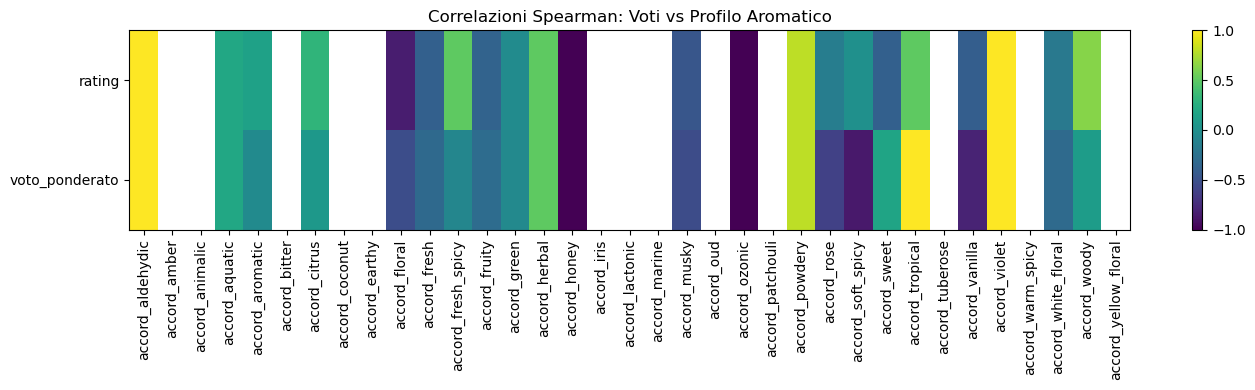

In [10]:

# %%
if corr_sub is not None and isinstance(corr_sub, pd.DataFrame) and not corr_sub.empty:
    plt.figure(figsize=(max(6, 0.4*len(corr_sub.columns)), max(4, 0.4*len(corr_sub.index))))
    plt.imshow(corr_sub, aspect="auto", interpolation="nearest")
    plt.xticks(ticks=range(len(corr_sub.columns)), labels=corr_sub.columns, rotation=90)
    plt.yticks(ticks=range(len(corr_sub.index)), labels=corr_sub.index)
    plt.title("Correlazioni Spearman: Voti vs Profilo Aromatico")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [11]:

# %%
top_list = []
if corr_sub is not None and isinstance(corr_sub, pd.DataFrame):
    for v in corr_sub.index:
        s = corr_sub.loc[v].dropna()
        if not s.empty:
            s_abs_sorted = s.reindex(s.abs().sort_values(ascending=False).index)
            for aroma, val in s_abs_sorted.head(30).items():
                top_list.append({"voto": v, "aroma": aroma, "corr_spearman": float(val)})

top_df = pd.DataFrame(top_list)
display(top_df.head(20))


,voto,aroma,corr_spearman
0,rating,accord_honey,-1.000000
1,rating,accord_aldehydic,1.000000
2,rating,accord_ozonic,-1.000000
3,rating,accord_violet,1.000000
4,rating,accord_floral,-0.842424
5,rating,accord_powdery,0.800000
6,rating,accord_woody,0.638554
7,rating,accord_fresh_spicy,0.501531
8,rating,accord_herbal,0.500000
9,rating,accord_tropical,0.500000
